# S2RA-regrid-zarr

**Date:** <br>
23 Feb 2022 <br>
**Background:** <br>
Issue -  <br>
**Author(s):**<br>
Thomas Moore<br>

### OOD documentation
https://opus.nci.org.au/display/DAE/Setting+up+a+Dask+Cluster+on+OOD

In [1]:
Author1 = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

In [2]:
import xarray as xr
import numpy as np
import xrft
import xesmf as xe
import scipy
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import os
import re
import cartopy.crs as ccrs
import proplot as pplt
from rechunker import rechunk
%config Completer.use_jedi = False

## import helper

In [3]:
import importlib.util
spec = importlib.util.spec_from_file_location("helper", "/g/data/v14/tm4888/code/helper-py/helper_tools.py")
helper = importlib.util.module_from_spec(spec)
spec.loader.exec_module(helper)

## OOD cluster

In [4]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=2,processes=1,memory="47GB",walltime='02:00:00')
client = Client(cluster)
cluster.scale(cores=24)

/g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [9]:
client

<Client: 'tcp://10.0.128.161:44865' processes=0 threads=0, memory=0 B>

# load Tgrid zarr

In [11]:
ds_S2_RA_ocean_masked_AUSWCPregion_nativeTgrid = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.masked.AUSWCPregion.nativeTgrid.zarr',consolidated=True)

In [12]:
ds_S2_RA_ocean_masked_AUSWCPregion_nativeUgrid = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.masked.AUSWCPregion.nativeUgrid.zarr',consolidated=True)

In [13]:
ds_S2_RA_ocean_masked_AUSWCPregion_nativeVgrid = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.masked.AUSWCPregion.nativeVgrid.zarr',consolidated=True)

# <hr>
# Tgrid - Regridding Step

## curvilinear grid

In [14]:
nav_lon = ds_S2_RA_ocean_masked_AUSWCPregion_nativeTgrid['lon'].compute()
nav_lat = ds_S2_RA_ocean_masked_AUSWCPregion_nativeTgrid['lat'].compute()

Text(0.5, 1.0, 'ACCESS-S2 Curvilinear grid over chosen region')

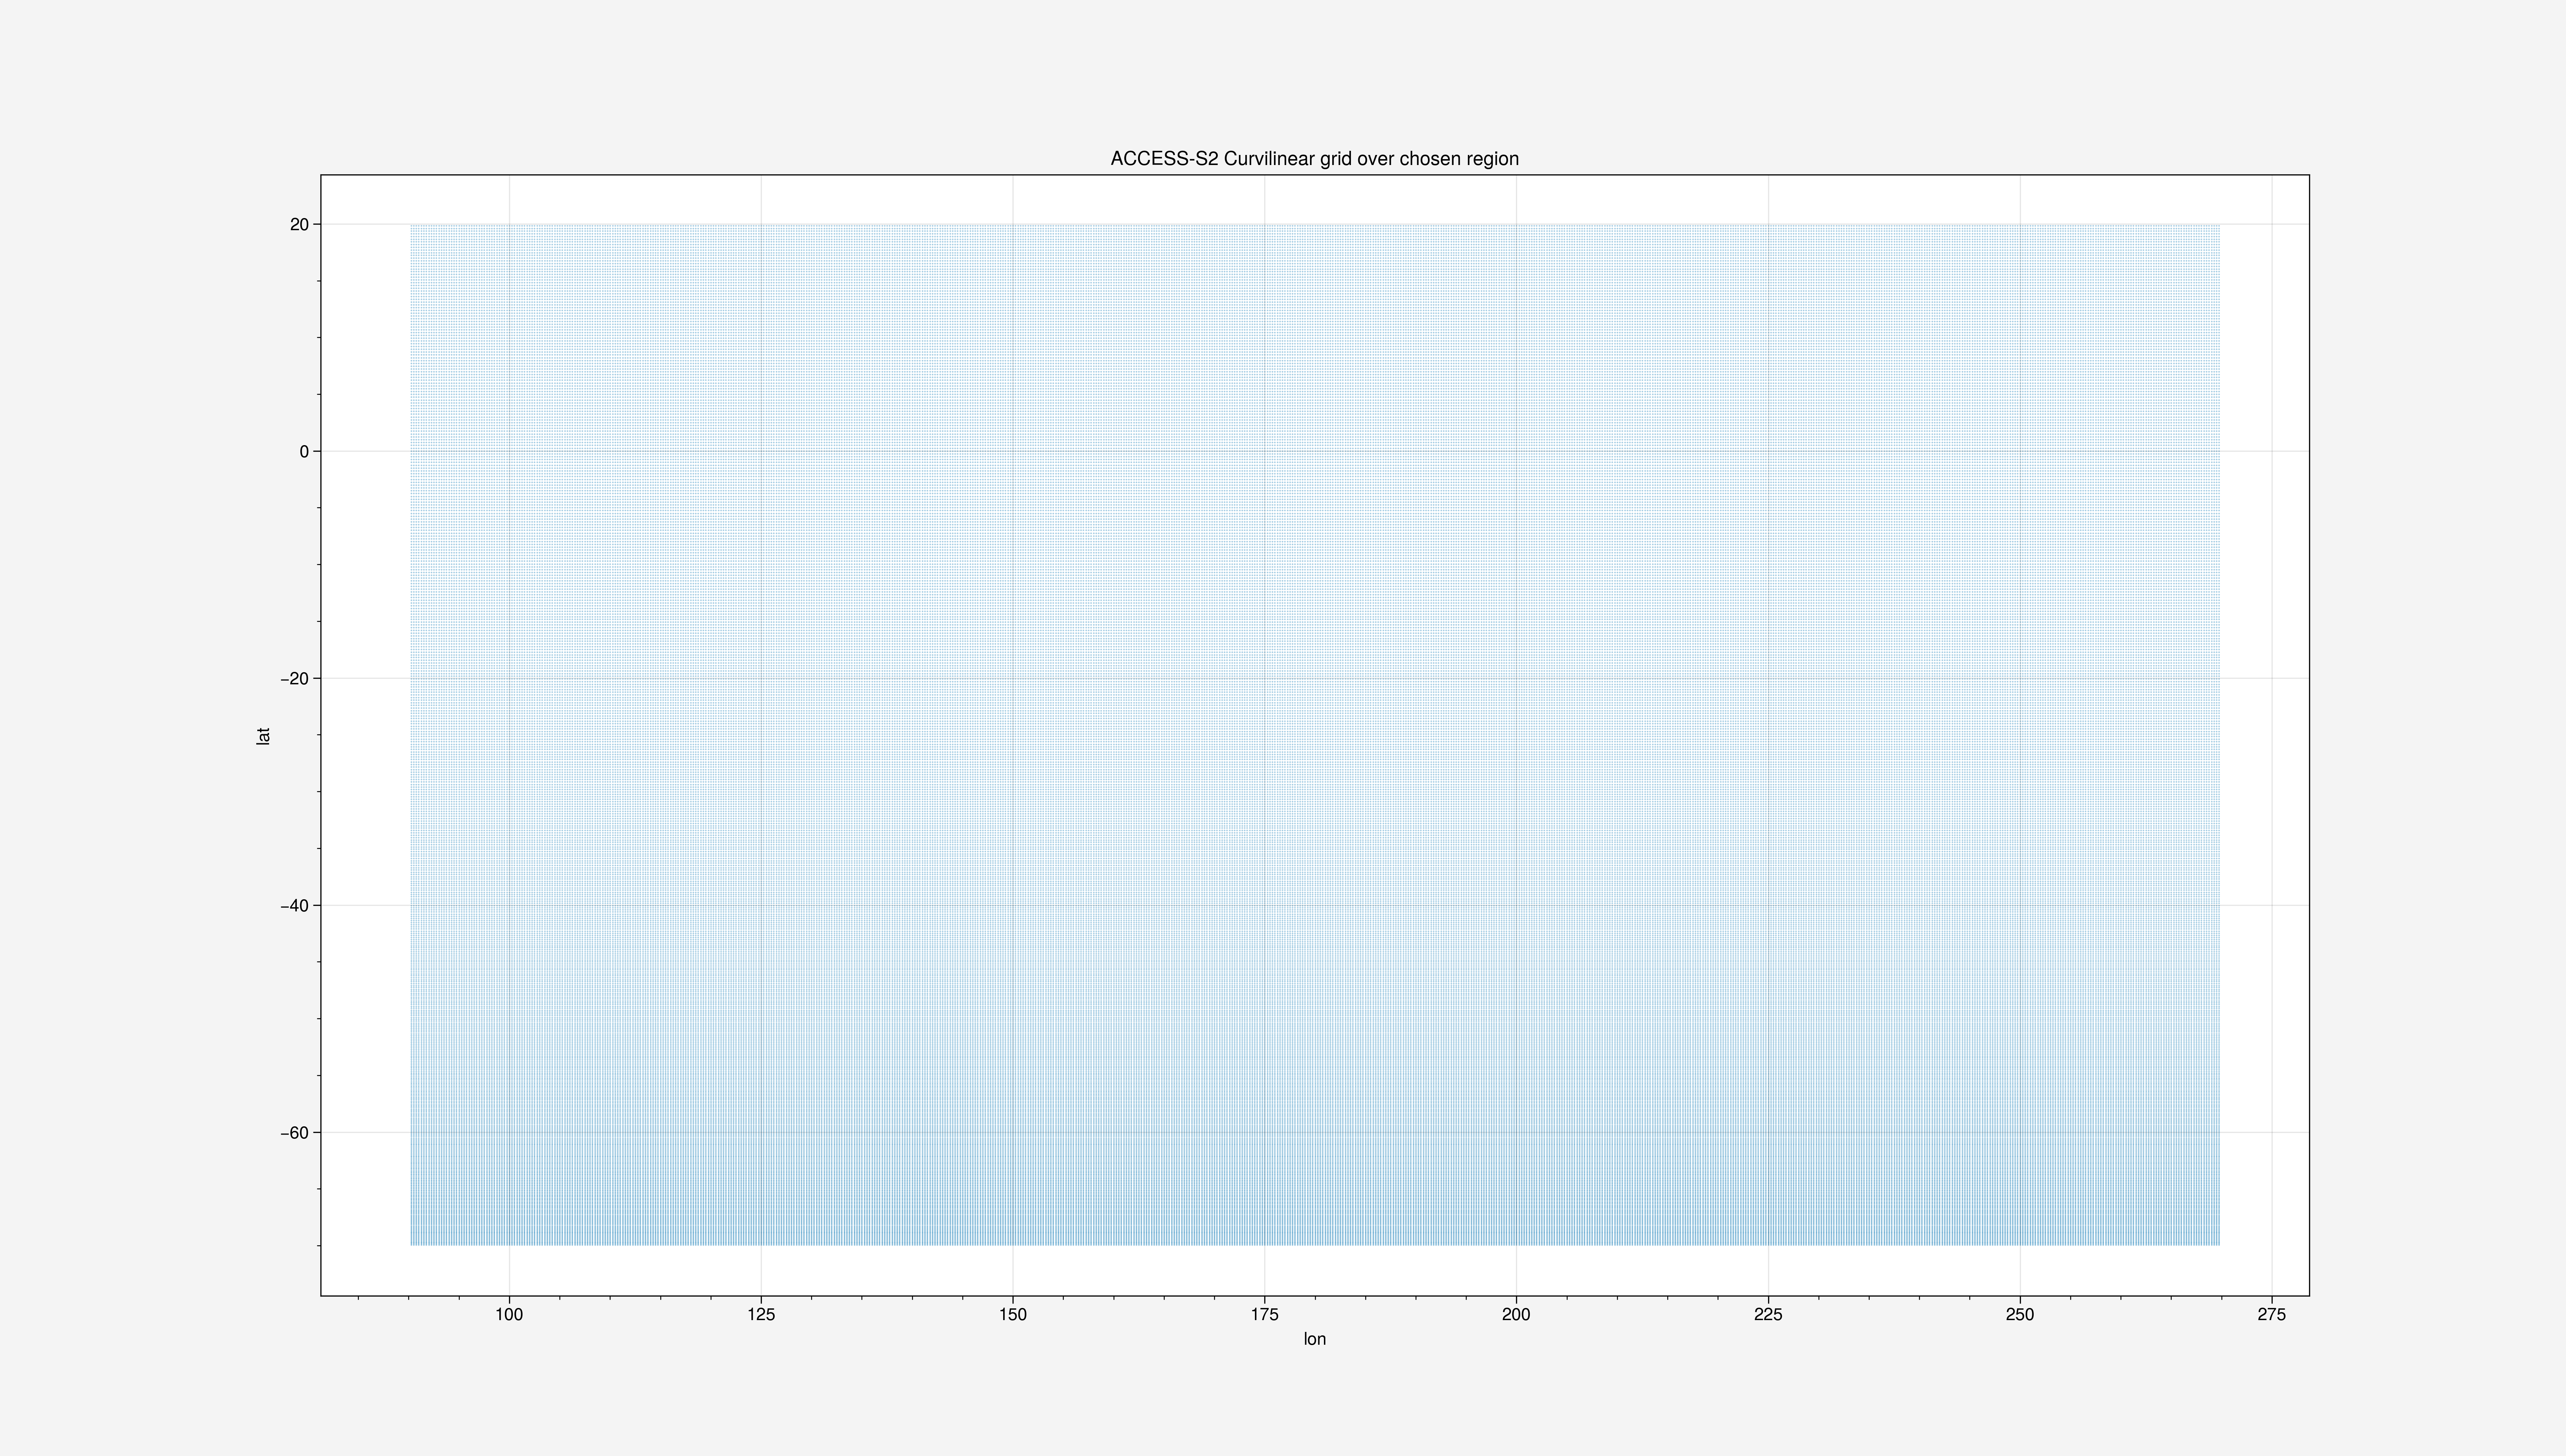

In [15]:
plt.scatter(nav_lon, nav_lat, s=0.01)  # plot grid locations
fig = plt.gcf()
fig.set_size_inches(10, 10)
fig.set_dpi(200)
#plt.ylim([-80, 90])
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('ACCESS-S2 Curvilinear grid over chosen region')

# Define new 0.25 degree grid

In [16]:
new_025deg_grid = xe.util.grid_2d(
    90, 270, 0.25, -70, 20, 0.25 
)  # latitude range and resolution
new_025deg_grid

<xarray.Dataset>
Dimensions:  (y: 360, x: 720, y_b: 361, x_b: 721)
Coordinates:
    lon      (y, x) float64 90.12 90.38 90.62 90.88 ... 269.1 269.4 269.6 269.9
    lat      (y, x) float64 -69.88 -69.88 -69.88 -69.88 ... 19.88 19.88 19.88
    lon_b    (y_b, x_b) float64 90.0 90.25 90.5 90.75 ... 269.5 269.8 270.0
    lat_b    (y_b, x_b) float64 -70.0 -70.0 -70.0 -70.0 ... 20.0 20.0 20.0 20.0
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    *empty*

Text(0.5, 1.0, 'uniform grid')

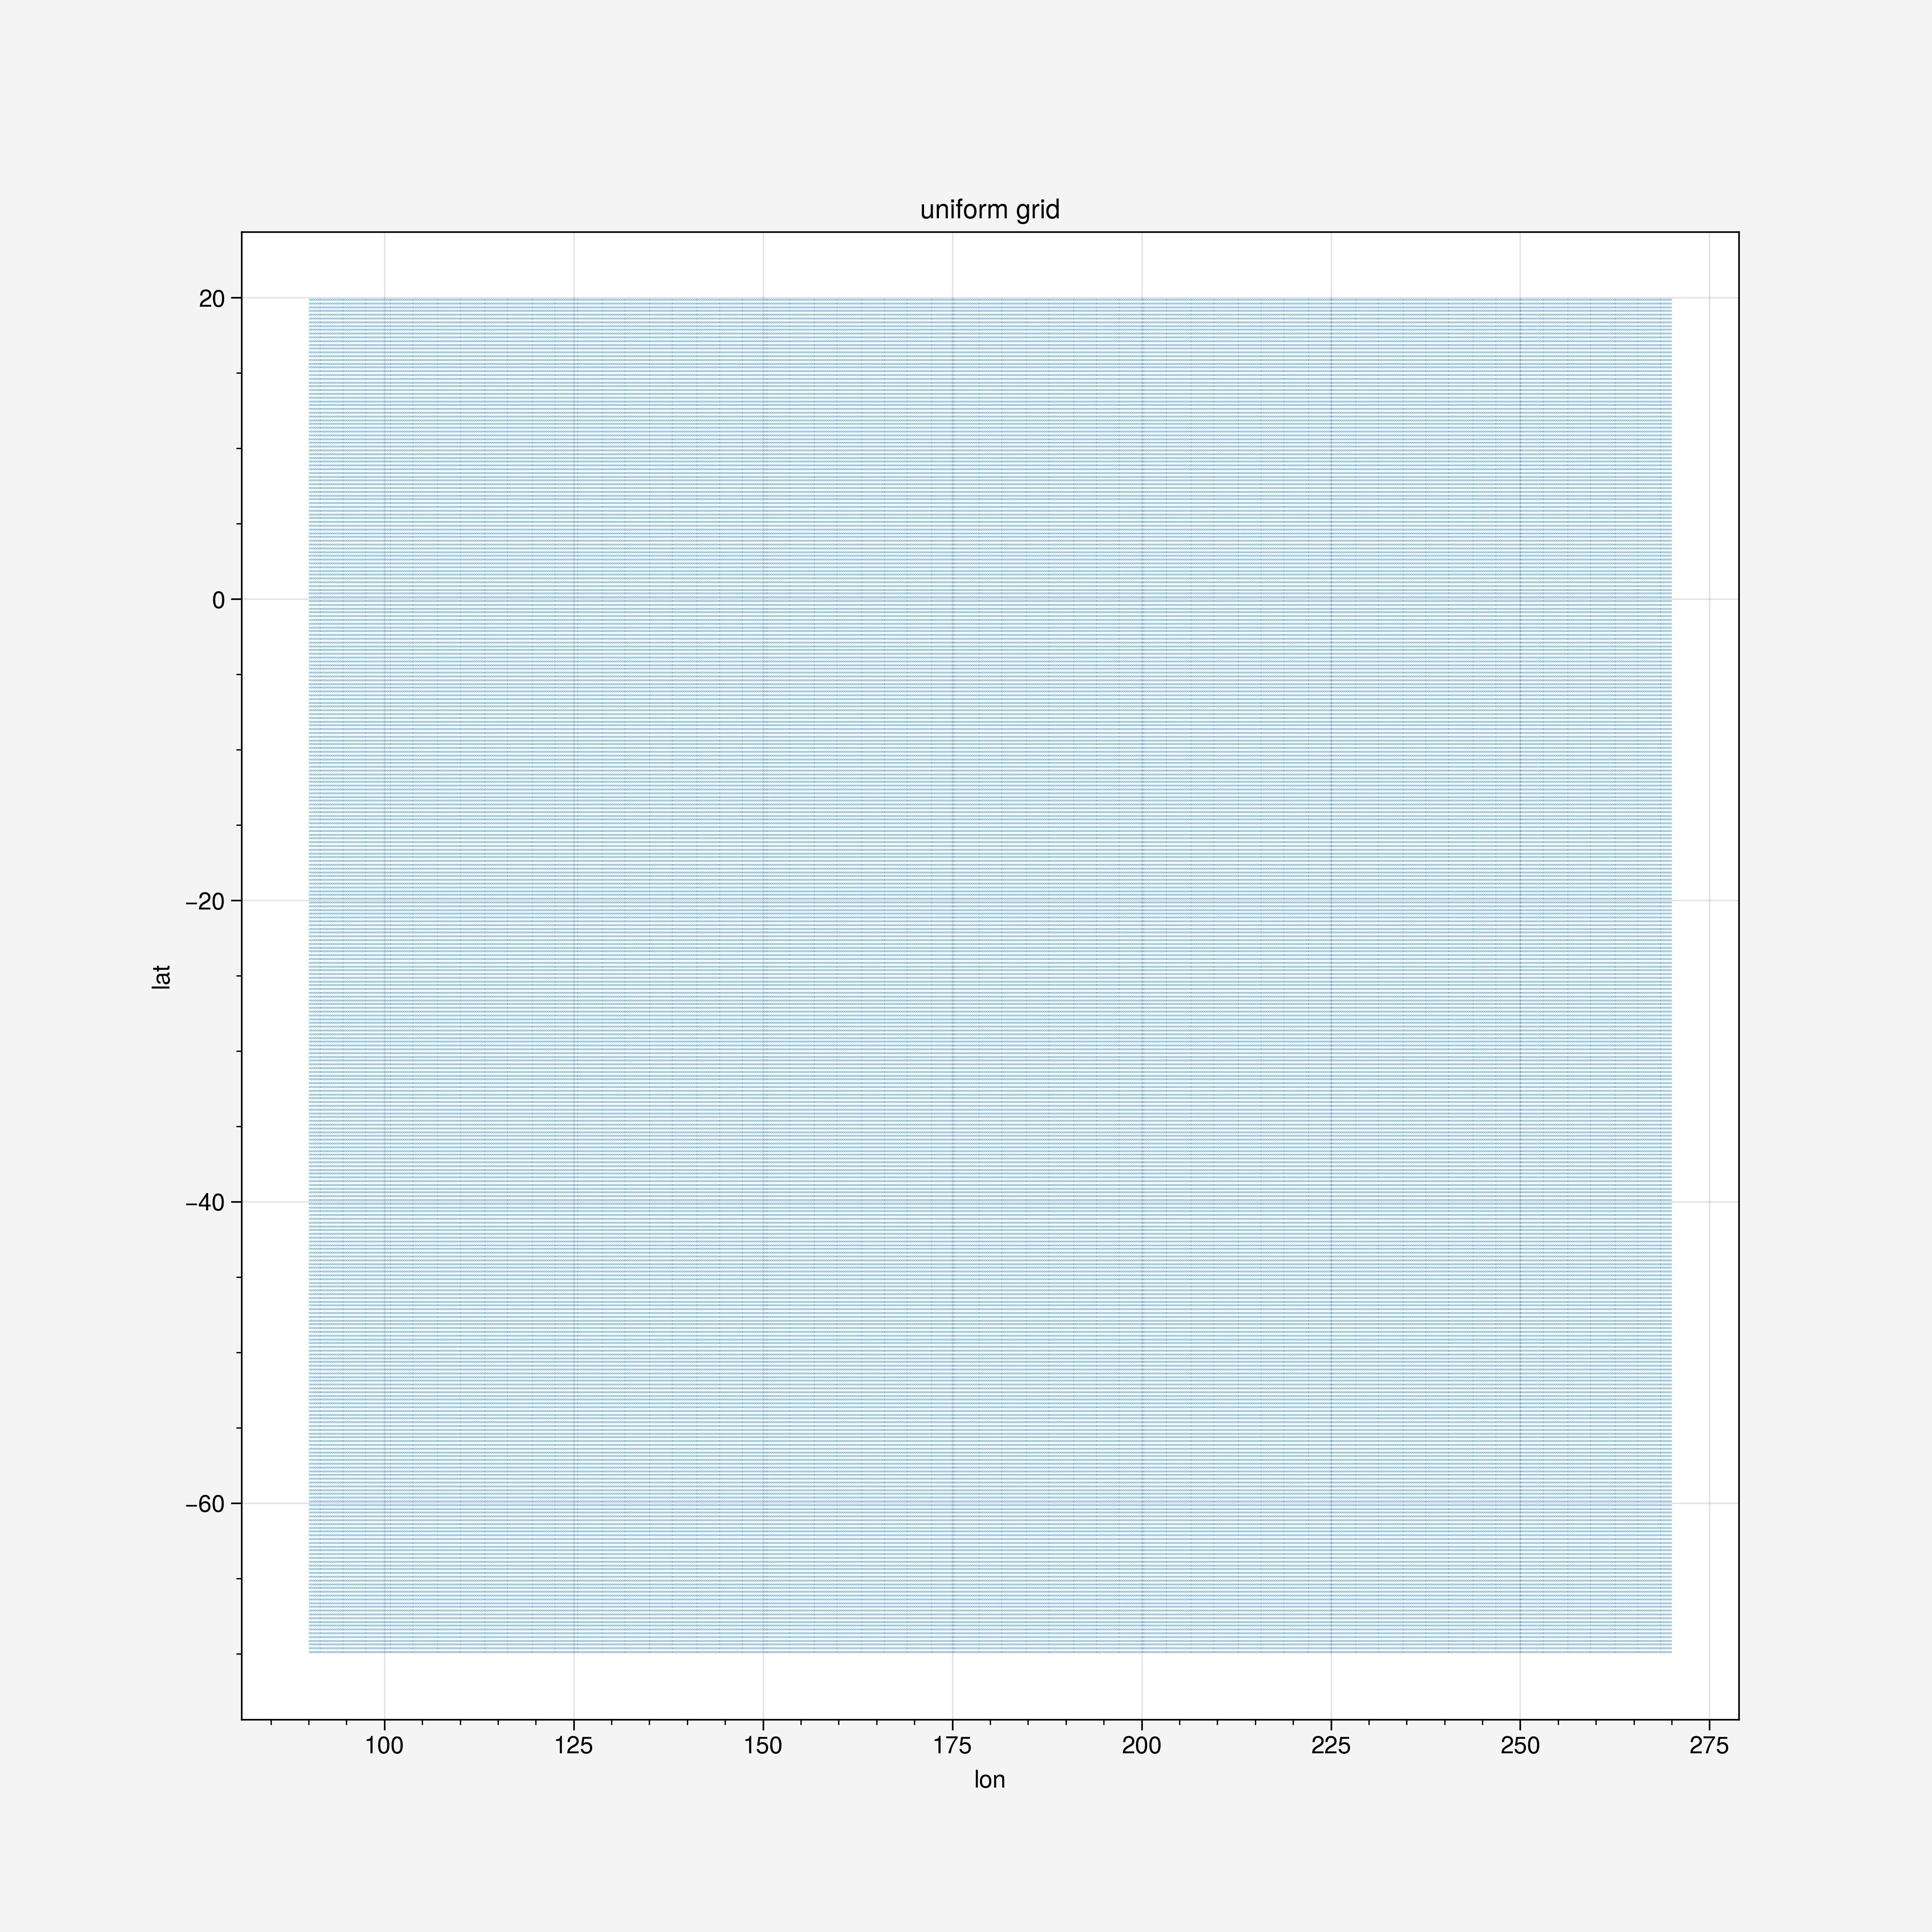

In [17]:
plt.scatter(new_025deg_grid.lon, new_025deg_grid.lat, s=0.01)  # plot grid locations
fig = plt.gcf()
fig.set_size_inches(10, 10)
fig.set_dpi(200)
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('uniform grid')

In [18]:
%%time
regridder_S2_025deg_Tgrid = xe.Regridder(ds_S2_RA_ocean_masked_AUSWCPregion_nativeTgrid, new_025deg_grid, method='bilinear', reuse_weights=False)

CPU times: user 16.3 s, sys: 1.94 s, total: 18.3 s
Wall time: 33.2 s


## EARTH SYSTEM MODELLING FRAMEWORK (NCAR / NOAA) - https://en.wikipedia.org/wiki/Earth_System_Modeling_Framework </br></br>  xESMF // https://github.com/JiaweiZhuang/xESMF/blob/master/README.rst

## $\bigstar$ solution to parallel regridding issue = https://github.com/JiaweiZhuang/xESMF/issues/71

#### regrid the dataset object

In [19]:
%%time
regridder_S2_025deg_Tgrid._grid_in = None
regridder_S2_025deg_Tgrid._grid_out = None
ds_S2_RA_ocean_masked_AUSWCPregion_T_025grid = regridder_S2_025deg_Tgrid(ds_S2_RA_ocean_masked_AUSWCPregion_nativeTgrid)

CPU times: user 4.81 s, sys: 249 ms, total: 5.06 s
Wall time: 5.94 s


# rename the coordinates to drop the x/y now that we are rectilinear

In [20]:
ds_S2_RA_ocean_masked_AUSWCPregion_T_025grid = ds_S2_RA_ocean_masked_AUSWCPregion_T_025grid.assign_coords({
    'x': ds_S2_RA_ocean_masked_AUSWCPregion_T_025grid.lon.isel(y=0),'y': ds_S2_RA_ocean_masked_AUSWCPregion_T_025grid.lat.isel(x=0)
    }).drop(['lon','lat']).rename({'x':'lon','y':'lat'})

In [21]:
ds_S2_RA_ocean_masked_AUSWCPregion_T_025grid

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 492)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-15 1981-02-15 ... 2021-12-15
  * lon      (lon) float64 90.12 90.38 90.62 90.88 ... 269.1 269.4 269.6 269.9
  * lat      (lat) float64 -69.88 -69.62 -69.38 -69.12 ... 19.38 19.62 19.88
Data variables: (12/13)
    areat    (lat, lon) float32 dask.array<chunksize=(360, 720), meta=np.ndarray>
    d20      (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    hc300    (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    mld1     (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    mld2     (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    ssh      (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    ...       ...
    sst      (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    td       (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    temp100  (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    temp200  (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    temp50   (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    temp500  (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

# U grid

In [22]:
%%time
regridder_S2_025deg_Ugrid = xe.Regridder(ds_S2_RA_ocean_masked_AUSWCPregion_nativeUgrid, new_025deg_grid, method='bilinear', reuse_weights=False)
regridder_S2_025deg_Ugrid._grid_in = None
regridder_S2_025deg_Ugrid._grid_out = None
ds_S2_RA_ocean_masked_AUSWCPregion_U_025grid = regridder_S2_025deg_Ugrid(ds_S2_RA_ocean_masked_AUSWCPregion_nativeUgrid)
ds_S2_RA_ocean_masked_AUSWCPregion_U_025grid = ds_S2_RA_ocean_masked_AUSWCPregion_U_025grid.assign_coords({
    'x': ds_S2_RA_ocean_masked_AUSWCPregion_U_025grid.lon.isel(y=0),'y': ds_S2_RA_ocean_masked_AUSWCPregion_U_025grid.lat.isel(x=0)
    }).drop(['lon','lat']).rename({'x':'lon','y':'lat'})

CPU times: user 15.1 s, sys: 440 ms, total: 15.5 s
Wall time: 21.7 s


# V grid

In [24]:
%%time
regridder_S2_025deg_Vgrid = xe.Regridder(ds_S2_RA_ocean_masked_AUSWCPregion_nativeVgrid, new_025deg_grid, method='bilinear', reuse_weights=False)
regridder_S2_025deg_Vgrid._grid_in = None
regridder_S2_025deg_Vgrid._grid_out = None
ds_S2_RA_ocean_masked_AUSWCPregion_V_025grid = regridder_S2_025deg_Vgrid(ds_S2_RA_ocean_masked_AUSWCPregion_nativeVgrid)
ds_S2_RA_ocean_masked_AUSWCPregion_V_025grid = ds_S2_RA_ocean_masked_AUSWCPregion_V_025grid.assign_coords({
    'x': ds_S2_RA_ocean_masked_AUSWCPregion_V_025grid.lon.isel(y=0),'y': ds_S2_RA_ocean_masked_AUSWCPregion_V_025grid.lat.isel(x=0)
    }).drop(['lon','lat']).rename({'x':'lon','y':'lat'})

CPU times: user 14.3 s, sys: 249 ms, total: 14.5 s
Wall time: 13.5 s


# Merge into one object on the new grid

In [25]:
ds_S2_RA_ocean_masked_AUSWCPregion_025grid = xr.merge([ds_S2_RA_ocean_masked_AUSWCPregion_T_025grid,ds_S2_RA_ocean_masked_AUSWCPregion_U_025grid,ds_S2_RA_ocean_masked_AUSWCPregion_V_025grid])

In [26]:
ds_S2_RA_ocean_masked_AUSWCPregion_025grid

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 492, depth: 75)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-15 1981-02-15 ... 2021-12-15
  * lon      (lon) float64 90.12 90.38 90.62 90.88 ... 269.1 269.4 269.6 269.9
  * lat      (lat) float64 -69.88 -69.62 -69.38 -69.12 ... 19.38 19.62 19.88
  * depth    (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
Data variables: (12/17)
    areat    (lat, lon) float32 dask.array<chunksize=(360, 720), meta=np.ndarray>
    d20      (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    hc300    (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    mld1     (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    mld2     (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    ssh      (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    ...       ...
    temp50   (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    temp500  (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    areau    (lat, lon) float32 dask.array<chunksize=(360, 720), meta=np.ndarray>
    u        (time, depth, lat, lon) float32 dask.array<chunksize=(1, 75, 360, 720), meta=np.ndarray>
    areav    (lat, lon) float32 dask.array<chunksize=(360, 720), meta=np.ndarray>
    v        (time, depth, lat, lon) float32 dask.array<chunksize=(1, 75, 360, 720), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

# Write out object to `zarr` collection

In [27]:
%%time
ds_S2_RA_ocean_masked_AUSWCPregion_025grid.to_zarr(store = '/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.TUV_025deg.zarr',consolidated=True)

CPU times: user 47.8 s, sys: 4.37 s, total: 52.2 s
Wall time: 2min 54s


# $\Uparrow$
# Main code
# -----------------

# Some checks, comparisons, and attempts at conservative regridding
# $\Downarrow$

# load back in 025 zarr collection

In [28]:
ds = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.TUV_025deg.zarr',consolidated=True)

In [29]:
ds

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 492, depth: 75)
Coordinates:
  * depth    (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * lat      (lat) float64 -69.88 -69.62 -69.38 -69.12 ... 19.38 19.62 19.88
  * lon      (lon) float64 90.12 90.38 90.62 90.88 ... 269.1 269.4 269.6 269.9
  * time     (time) datetime64[ns] 1981-01-15 1981-02-15 ... 2021-12-15
Data variables: (12/17)
    areat    (lat, lon) float32 dask.array<chunksize=(360, 720), meta=np.ndarray>
    areau    (lat, lon) float32 dask.array<chunksize=(360, 720), meta=np.ndarray>
    areav    (lat, lon) float32 dask.array<chunksize=(360, 720), meta=np.ndarray>
    d20      (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    hc300    (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    mld1     (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    ...       ...
    temp100  (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    temp200  (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    temp50   (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    temp500  (time, lat, lon) float32 dask.array<chunksize=(12, 360, 720), meta=np.ndarray>
    u        (time, depth, lat, lon) float32 dask.array<chunksize=(1, 75, 360, 720), meta=np.ndarray>
    v        (time, depth, lat, lon) float32 dask.array<chunksize=(1, 75, 360, 720), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

# plot up an SST timeslice for this unmasked regrid to 0.25

In [17]:
SST_unmasked = ds_S2_RA_ocean_masked_AUSWCPregion_025grid.sst.isel({'time':300}).compute()

(120.0, 160.0)

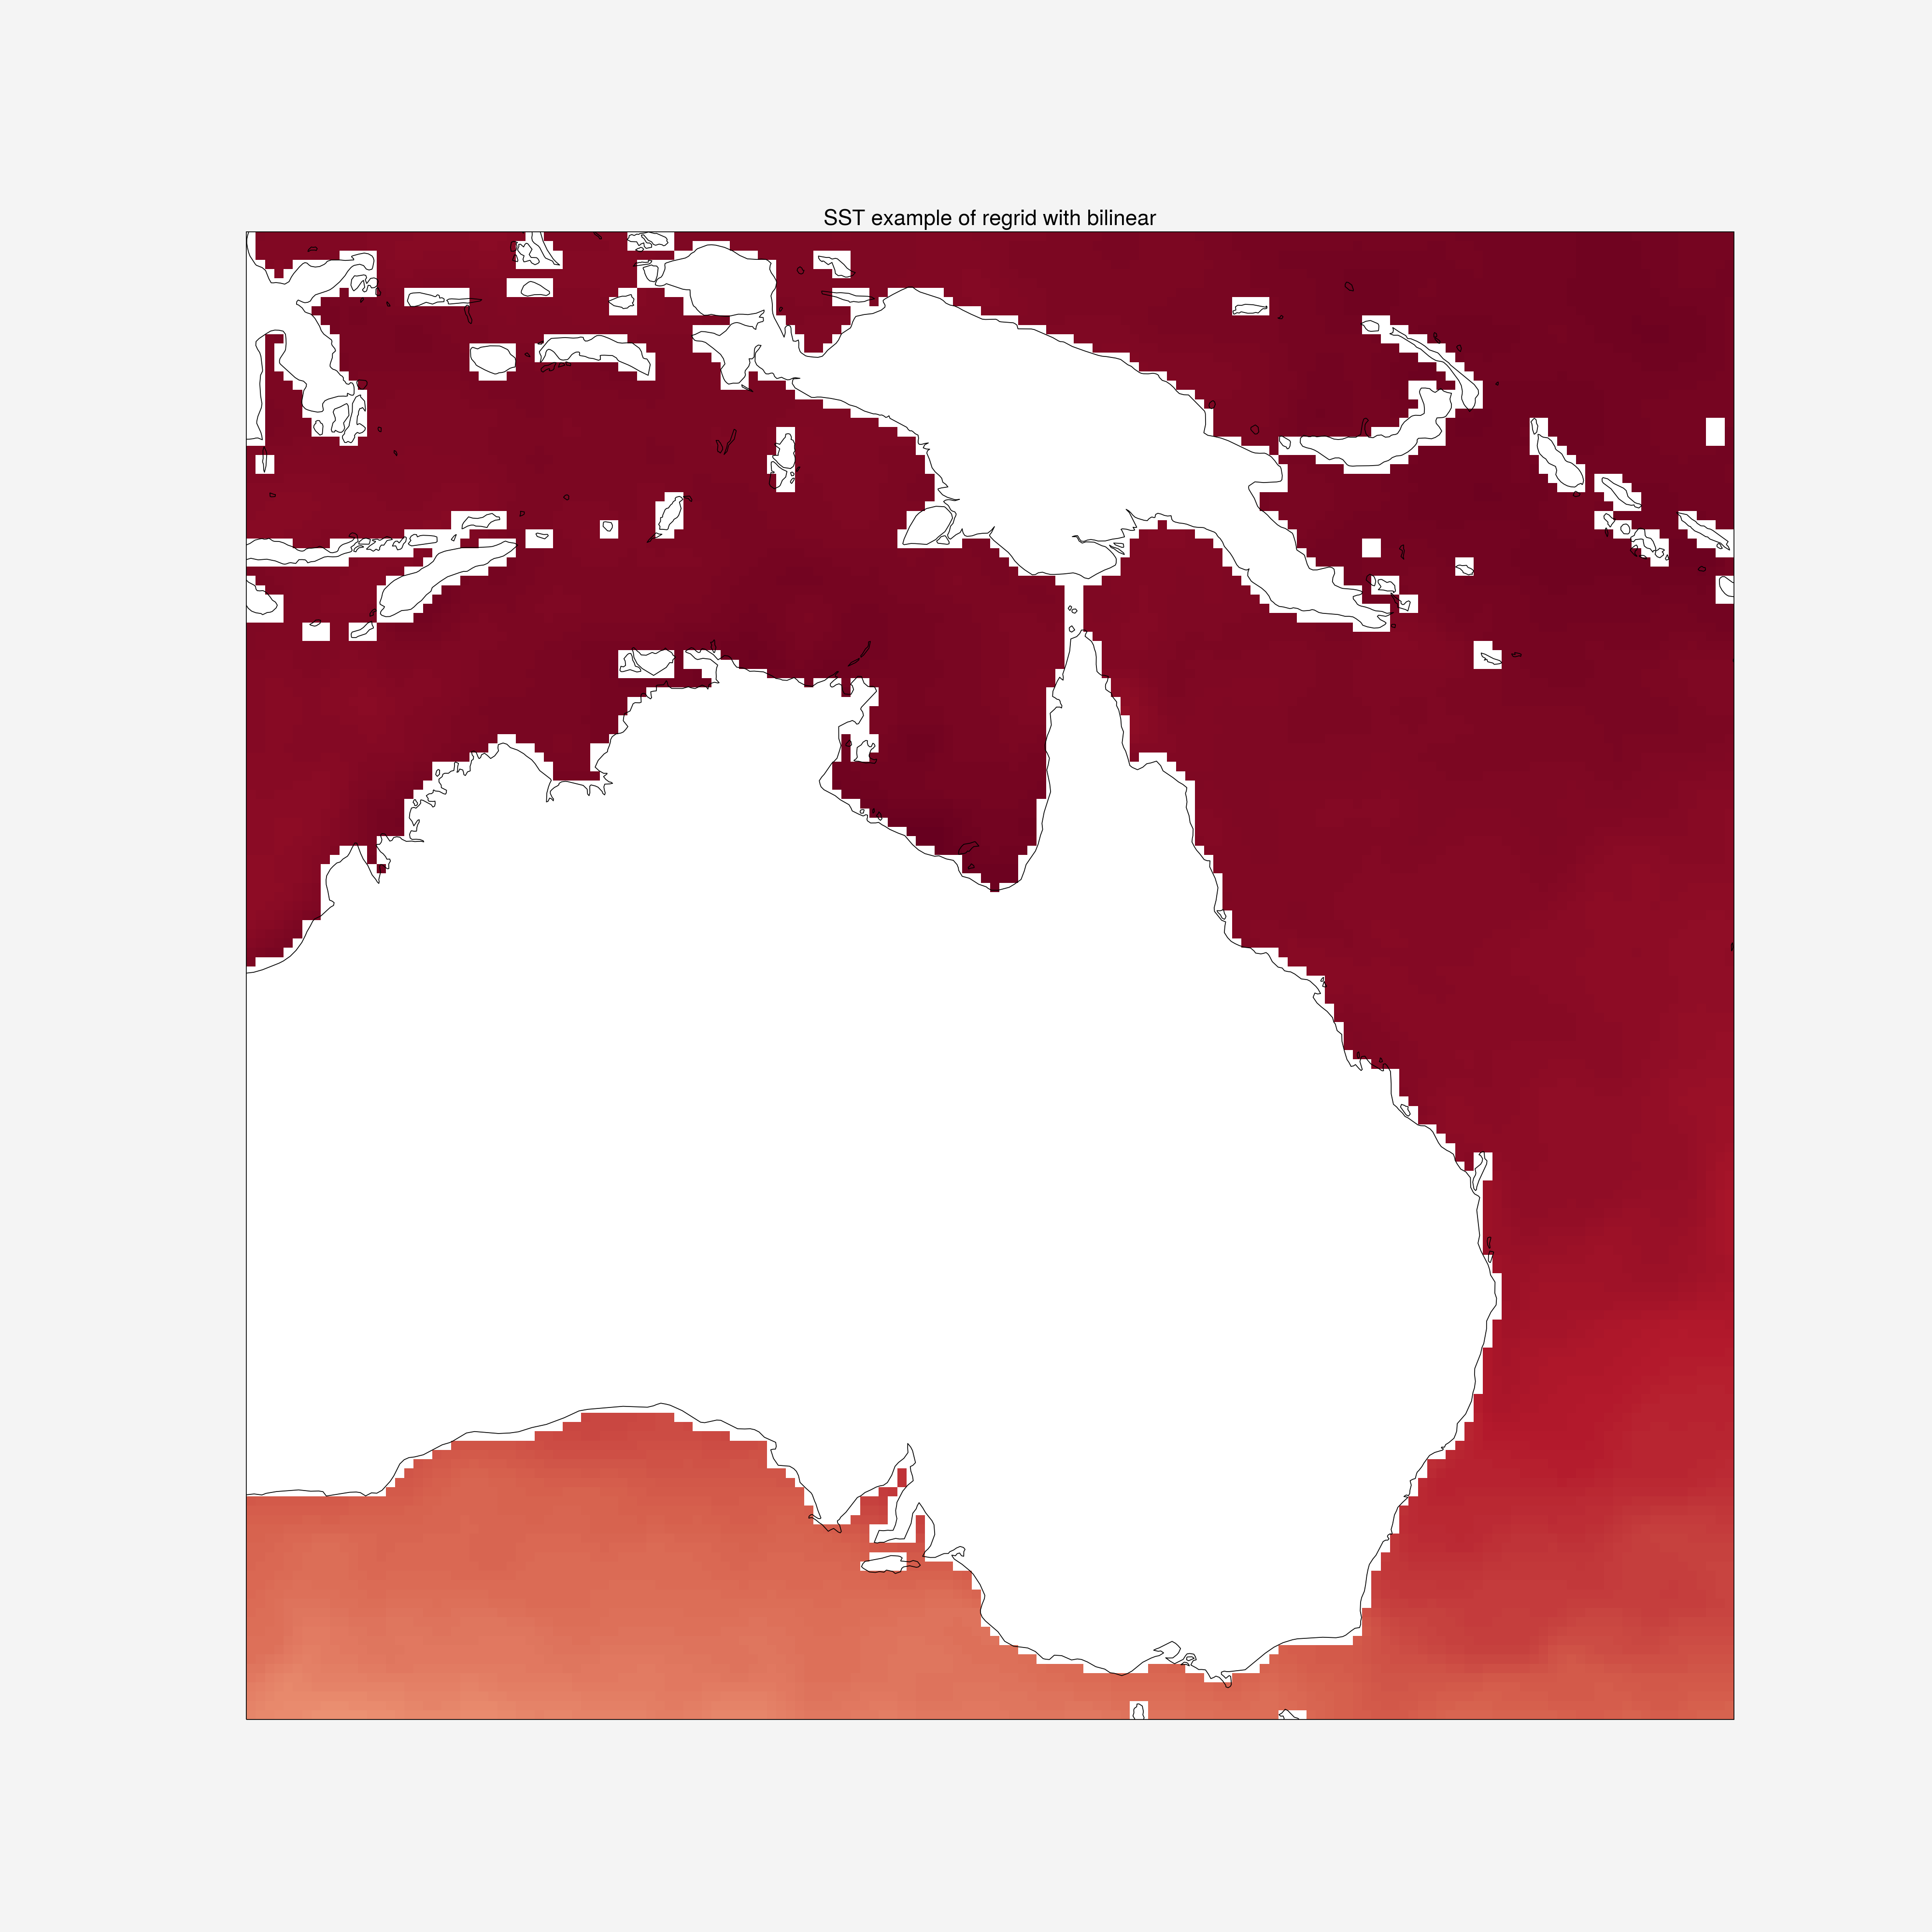

In [18]:
fig1 = plt.figure(figsize=(20,20),dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
SST_unmasked.plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), robust=False, add_colorbar=False
)
ax.set_title('SST example of regrid with bilinear', fontsize=16)
ax.coastlines()
ax.set_ylim([-40, 0])
ax.set_xlim([120, 160])

# How does this compare to the RAW netcdf?

In [19]:
nc_SST = xr.open_dataset('/g/data/ux62/access-s2/reanalysis/ocean/sst/mo_sst_2014.nc')

In [20]:
nc_SST

<xarray.Dataset>
Dimensions:            (y: 1021, x: 1442, deptht: 1, ndepth_bounds: 2, ncorners: 4, time_counter: 12, tbnds: 2)
Coordinates:
  * deptht             (deptht) float32 0.5058
    nav_lat            (y, x) float32 ...
    nav_lon            (y, x) float32 ...
  * time_counter       (time_counter) datetime64[ns] 2014-01-16T12:00:00 ... ...
Dimensions without coordinates: y, x, ndepth_bounds, ncorners, tbnds
Data variables:
    areat              (y, x) float32 ...
    deptht_bounds      (deptht, ndepth_bounds) float32 ...
    latt_bounds        (y, x, ncorners) float32 ...
    lont_bounds        (y, x, ncorners) float32 ...
    sst                (time_counter, deptht, y, x) float32 ...
    time_counter_bnds  (time_counter, tbnds) datetime64[ns] ...
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    24/12/2018 13:06:23 -0000
    history:      Wed Dec  2 19:11:24 AEDT 2020: Monthly sst created using pr...
    NCO:          netCDF Operators version 4.9.2 (Homepage = http://nco.sf.ne...

/g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


(120.0, 160.0)

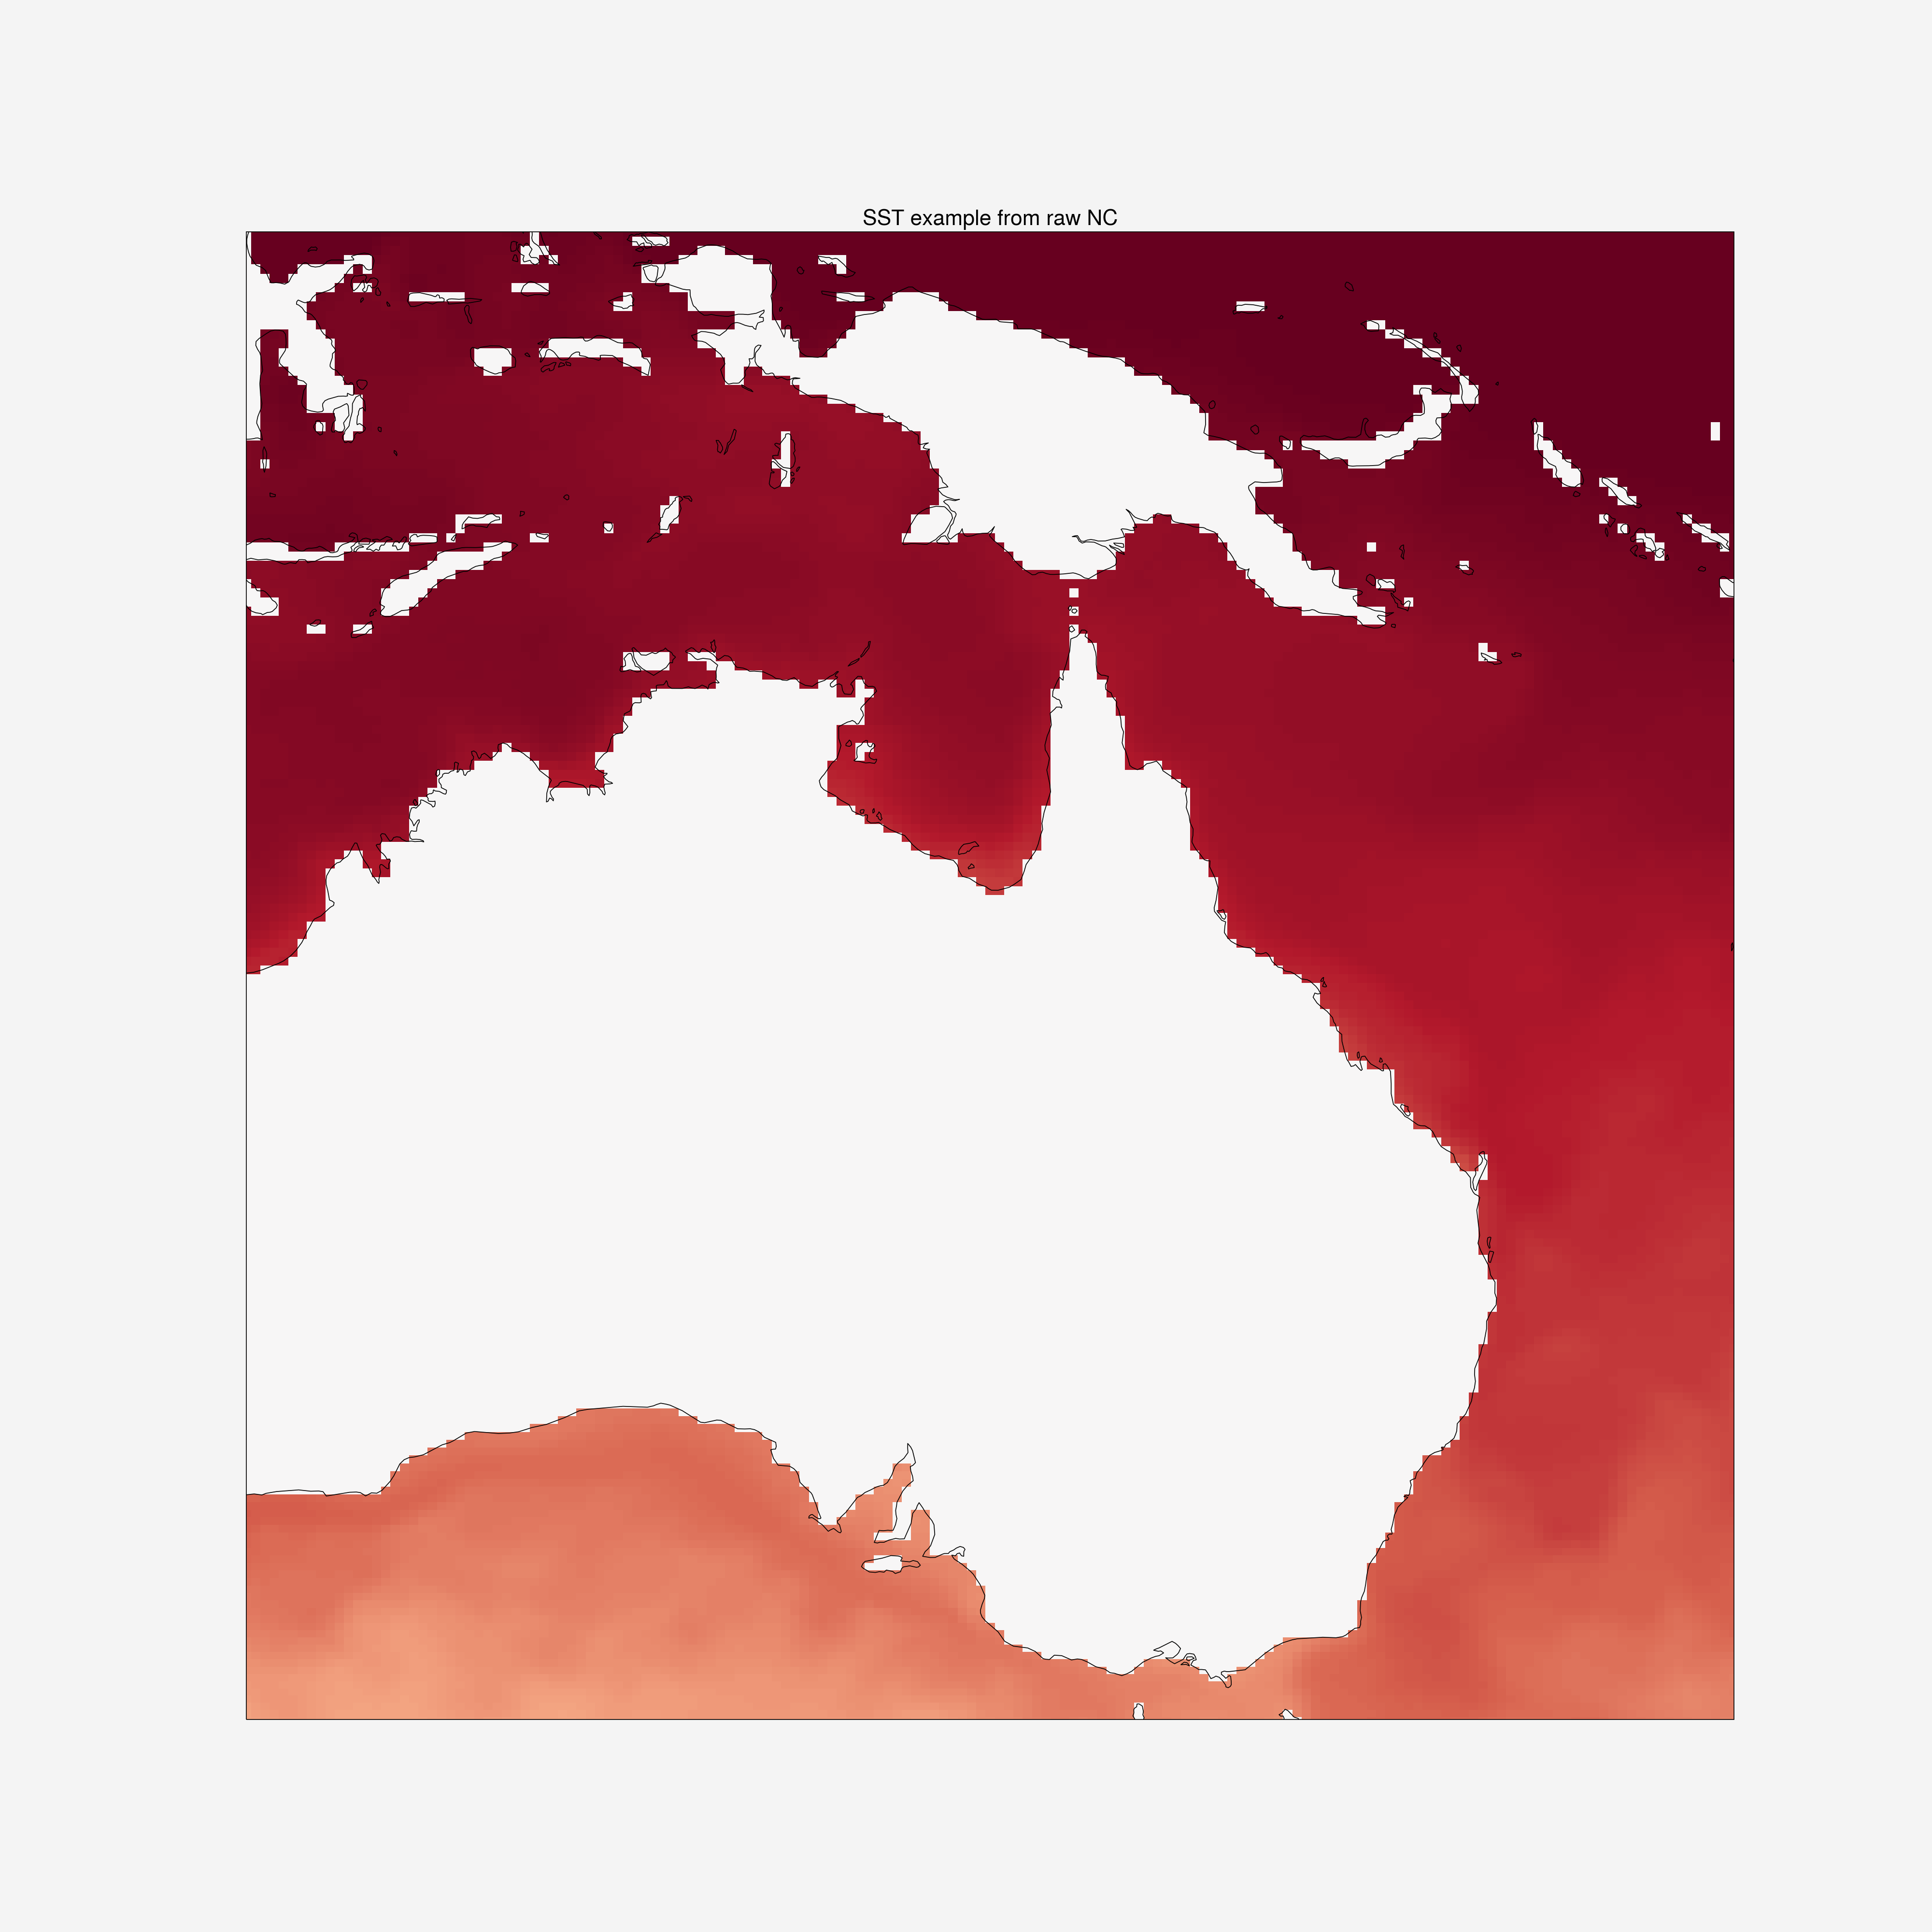

In [21]:
fig2 = plt.figure(figsize=(20,20),dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
nc_SST.sst.isel(time_counter=6).squeeze().plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), x ='nav_lon',y='nav_lat', robust=True, add_colorbar=False 
)
ax.set_title('SST example from raw NC', fontsize=16)
ax.coastlines()
ax.set_ylim([-40, 0])
ax.set_xlim([120, 160])

# How does this compare to base zarr?

(120.0, 160.0)

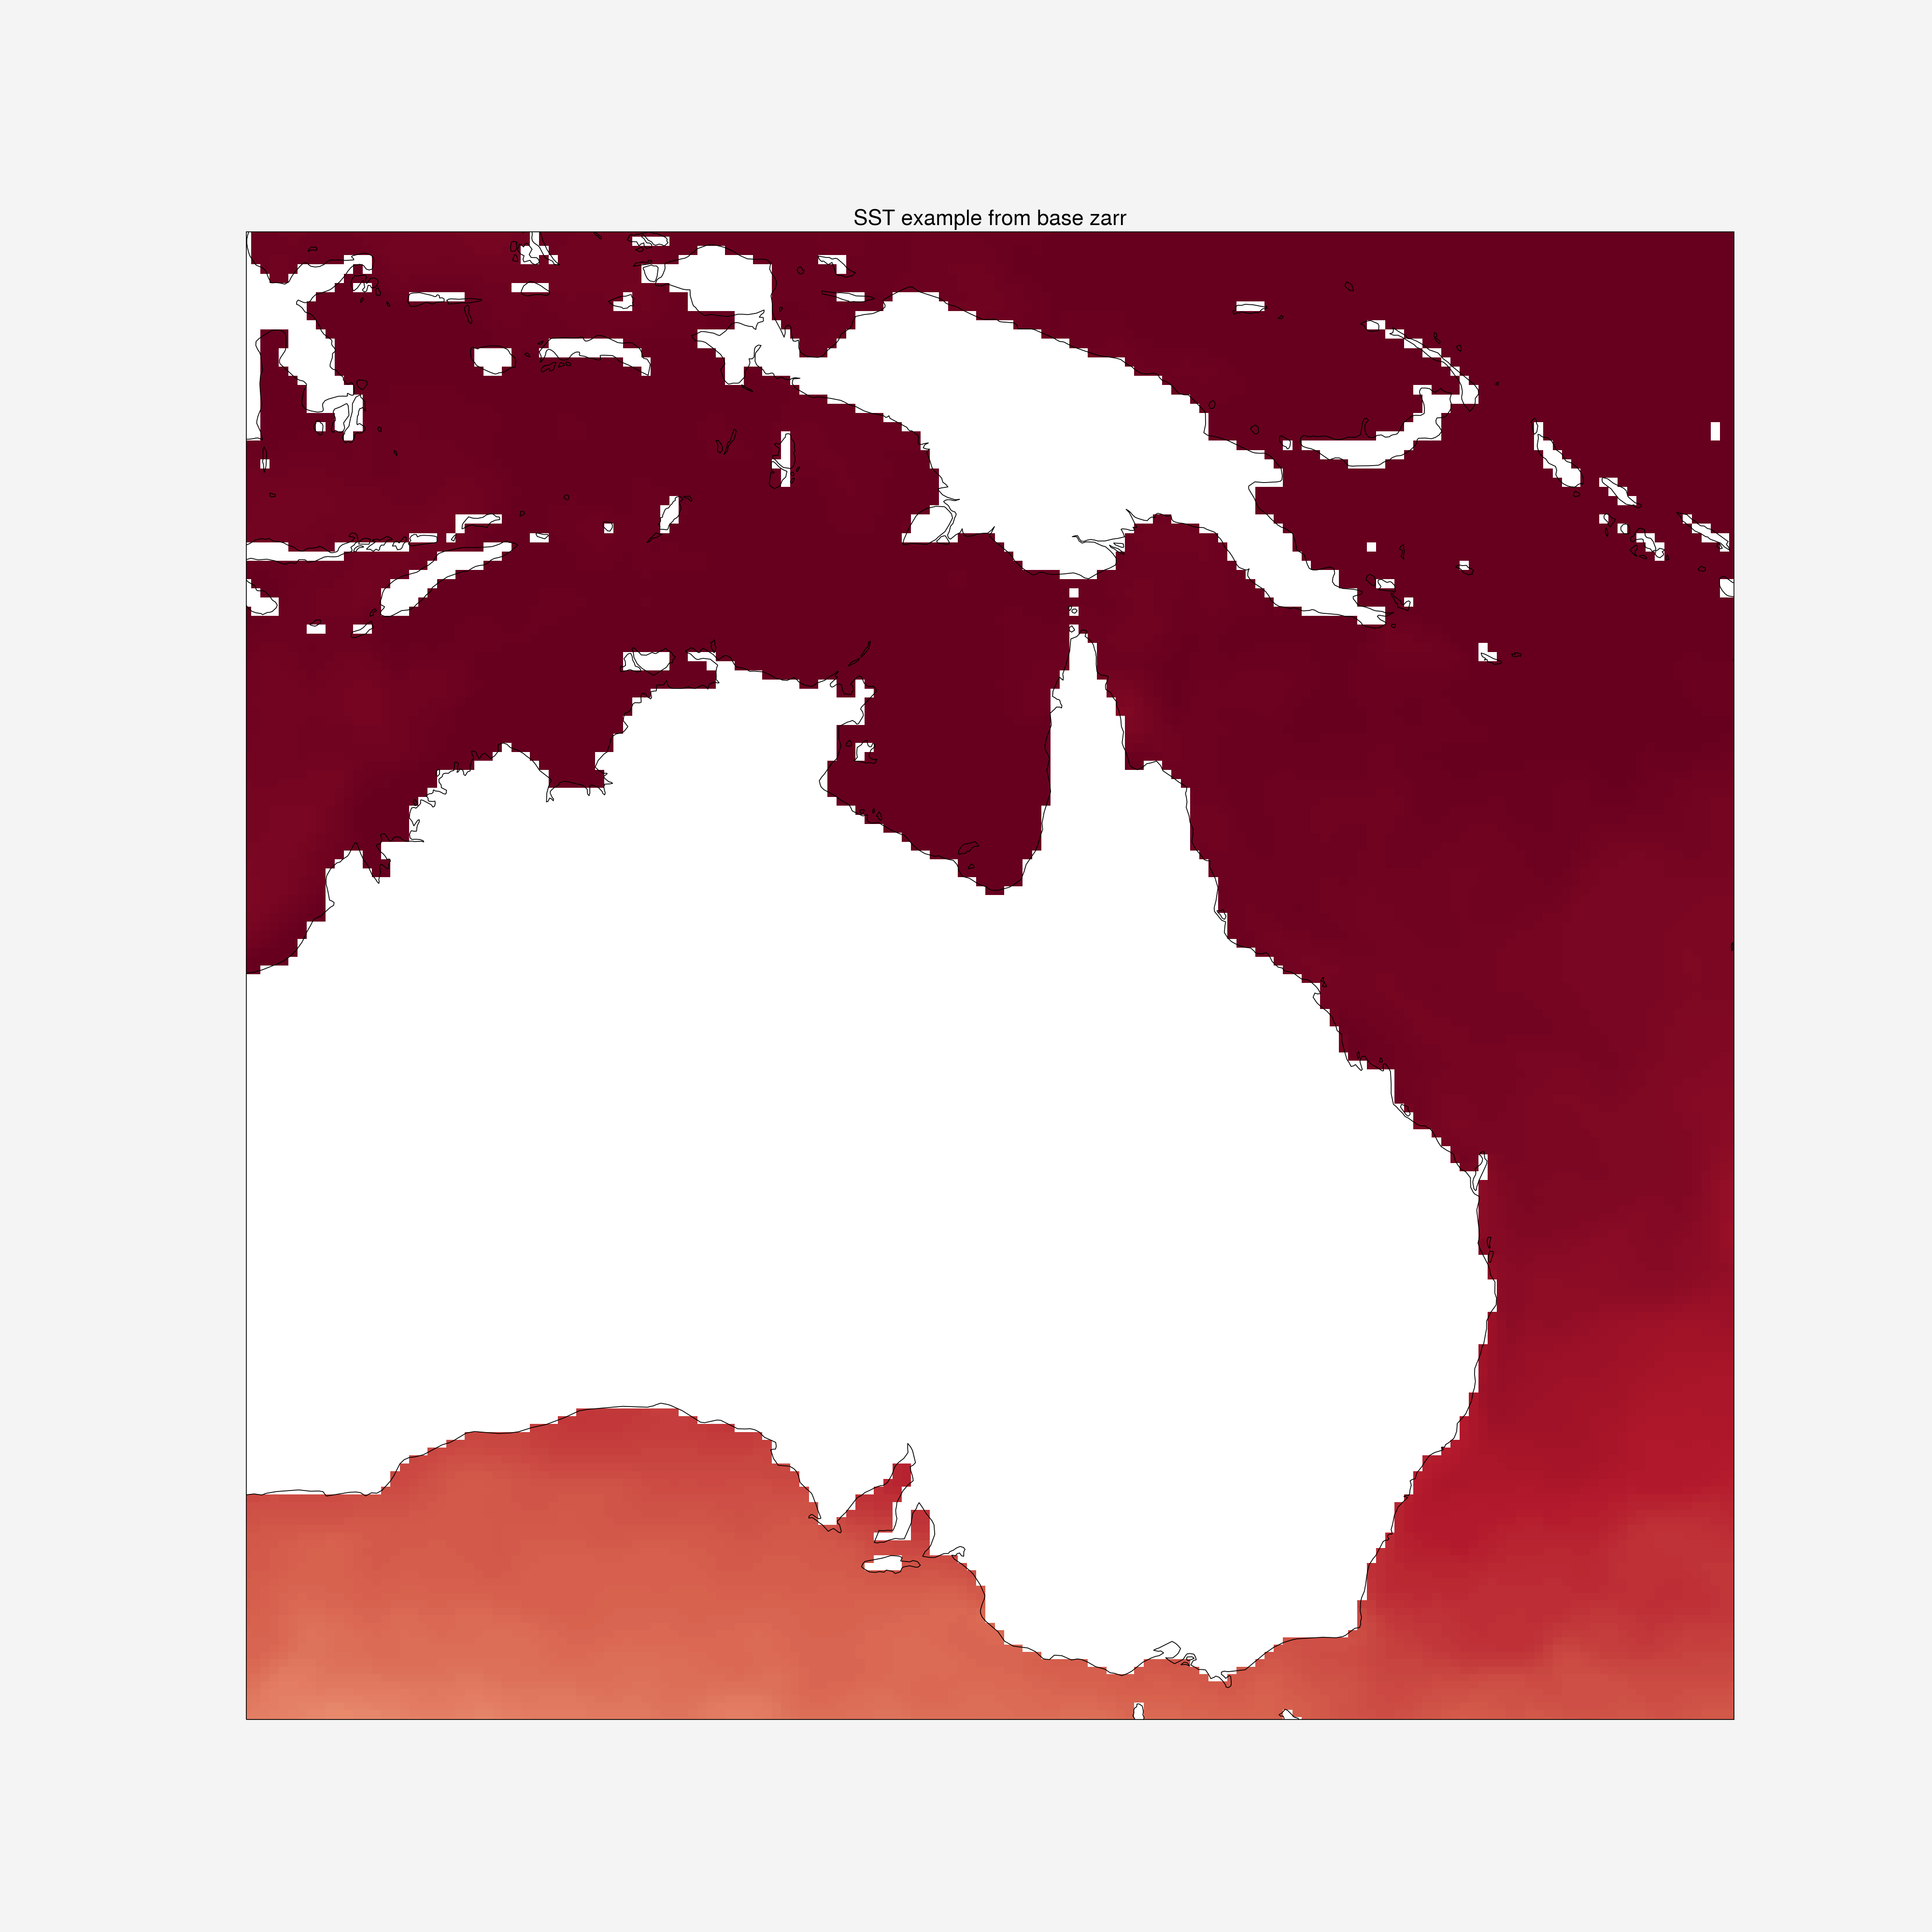

In [22]:
fig2 = plt.figure(figsize=(20,20),dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ds_S2_RA_ocean_masked_AUSWCPregion_nativeTgrid.sst.isel(time=300).plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), x ='lon',y='lat', robust=True, add_colorbar=False 
)
ax.set_title('SST example from base zarr', fontsize=16)
ax.coastlines()
ax.set_ylim([-40, 0])
ax.set_xlim([120, 160])

# Does adding a "mask" variable to the input help with xESMF bilinear?

In [23]:
sst_for_mask = ds_S2_RA_ocean_masked_AUSWCPregion_nativeTgrid.sst.isel(time=0)
ds_S2_RA_ocean_masked_AUSWCPregion_nativeTgrid['mask'] = xr.where(np.isfinite(sst_for_mask), 1, 0)

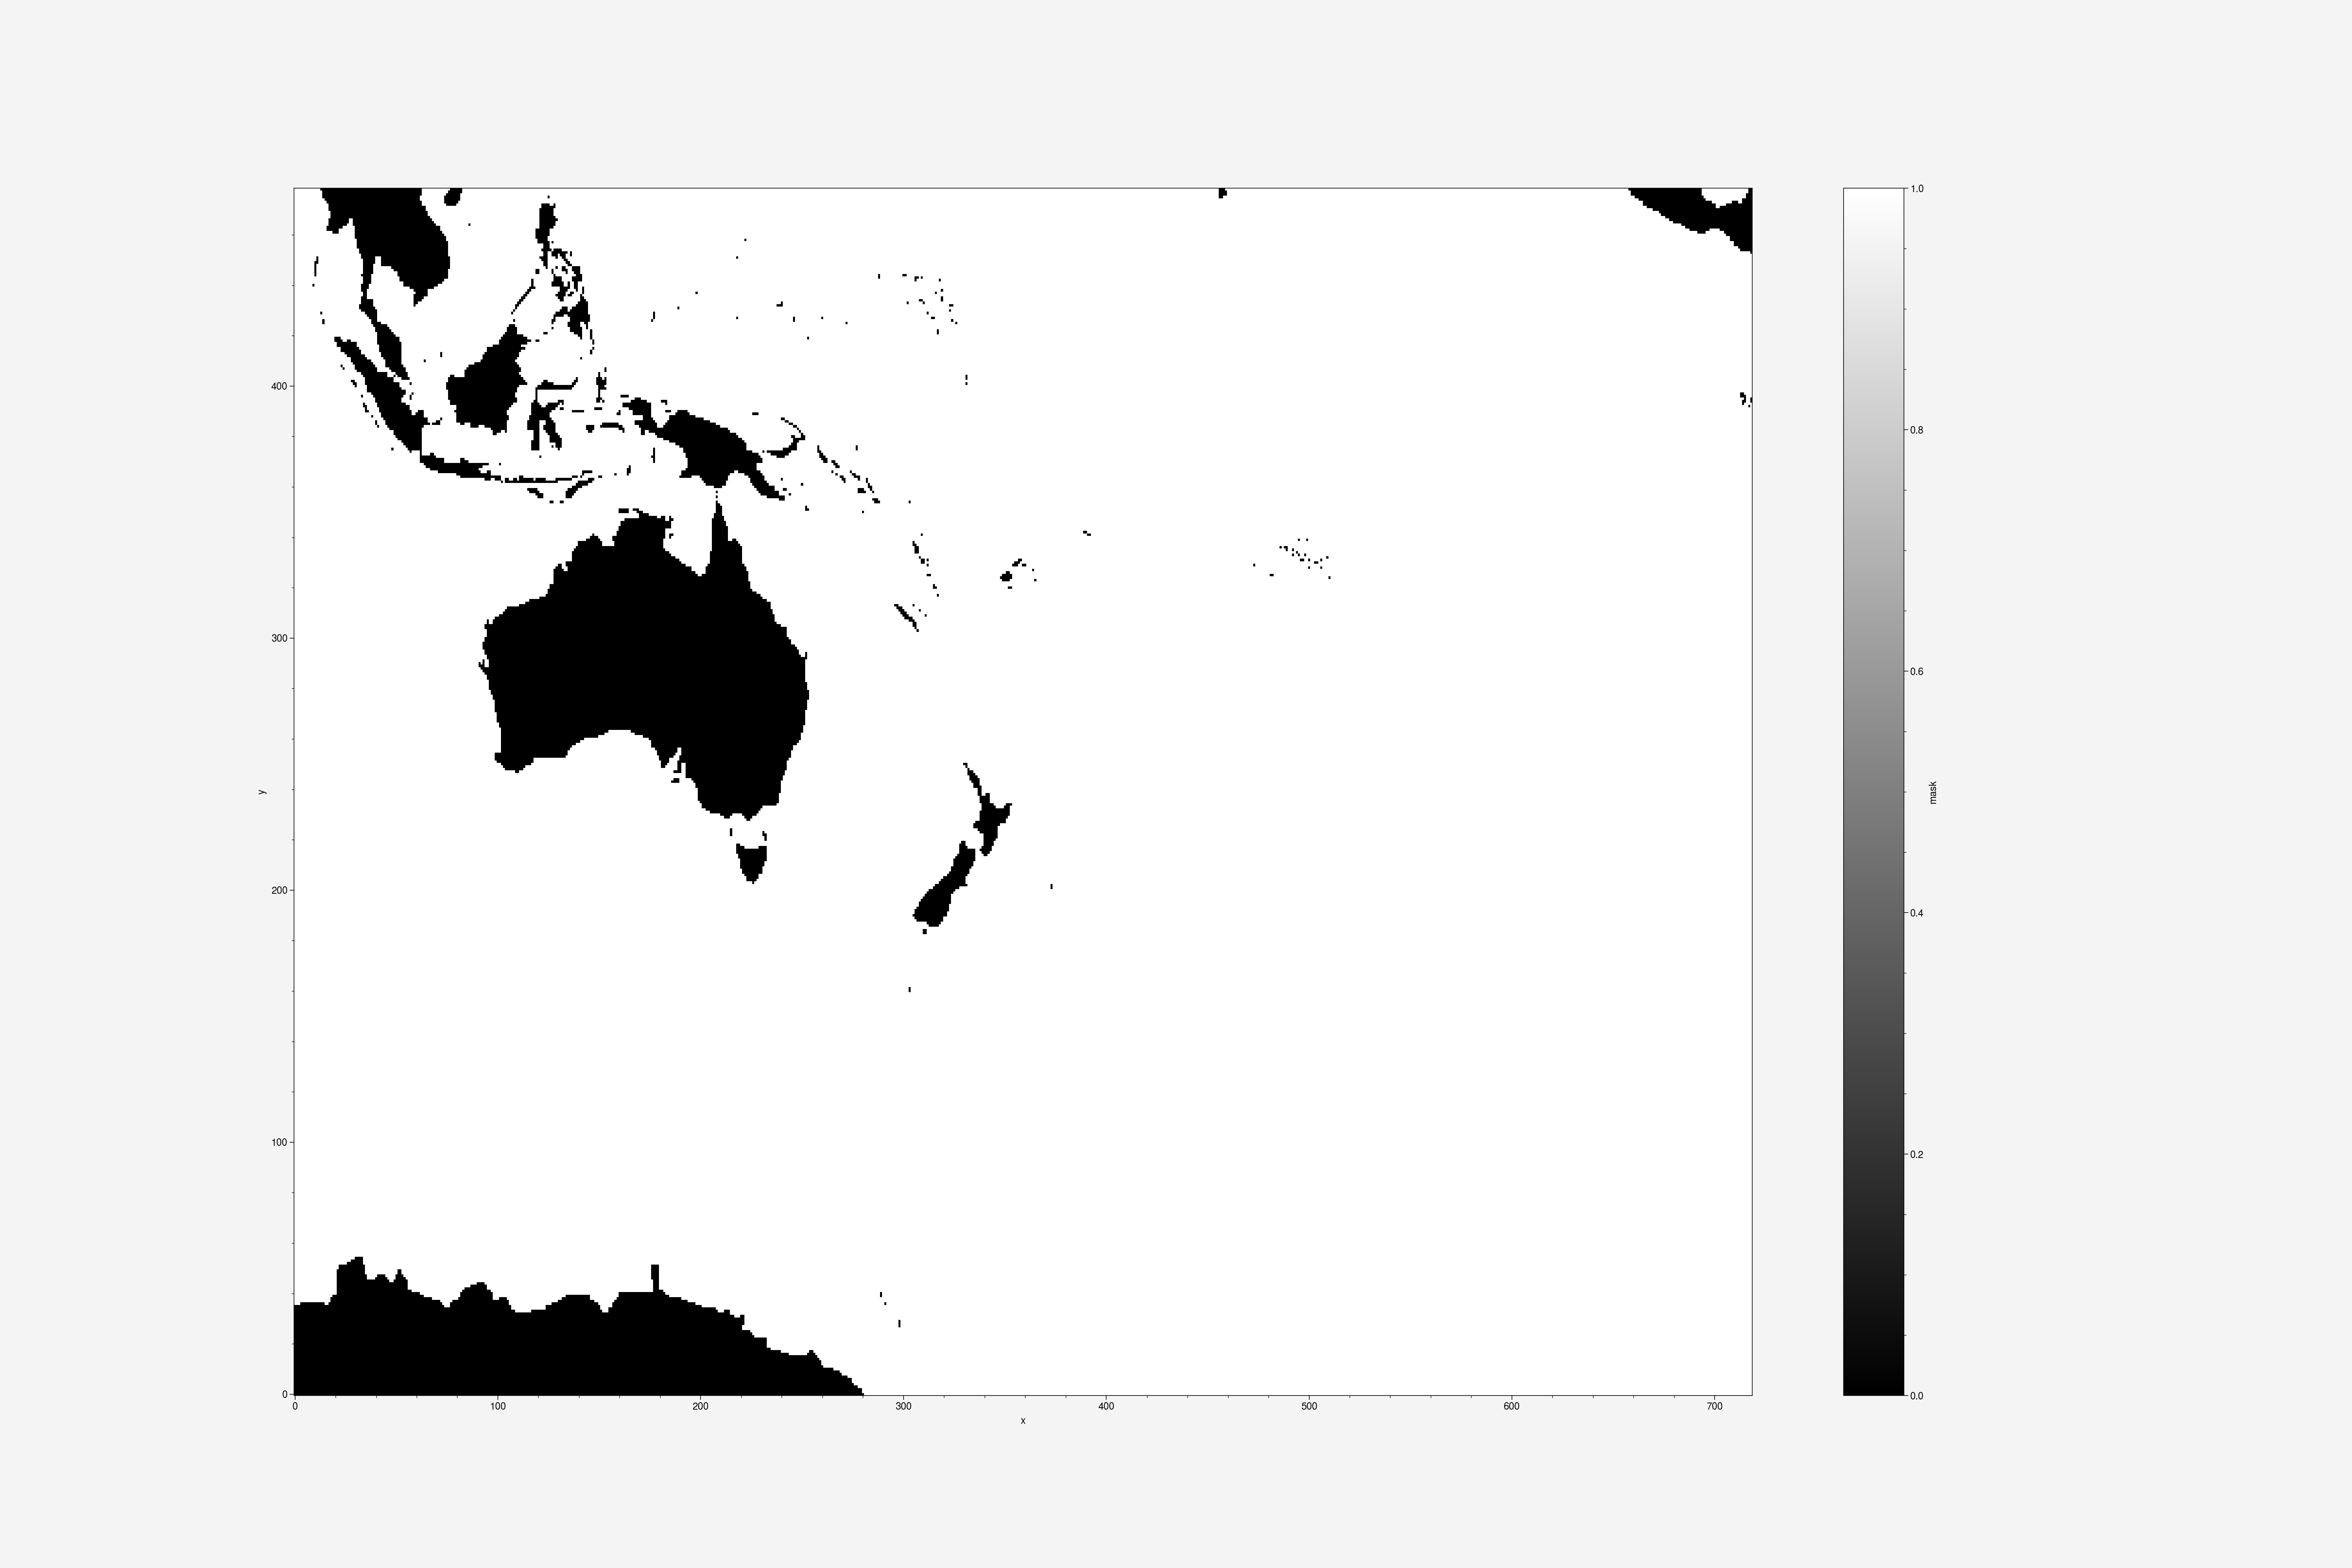

In [37]:
ds_S2_RA_ocean_masked_AUSWCPregion_nativeTgrid['mask'].plot(cmap='binary_r',figsize=(30,20))

In [25]:
%%time
regridder_S2_025deg_wMask_Tgrid = xe.Regridder(ds_S2_RA_ocean_masked_AUSWCPregion_nativeTgrid, new_025deg_grid, method='bilinear', reuse_weights=False)

CPU times: user 14.2 s, sys: 513 ms, total: 14.7 s
Wall time: 14.1 s


In [26]:
%%time
regridder_S2_025deg_wMask_Tgrid._grid_in = None
regridder_S2_025deg_wMask_Tgrid._grid_out = None
ds_S2_RA_ocean_masked_AUSWCPregion_wMask025grid = regridder_S2_025deg_wMask_Tgrid(ds_S2_RA_ocean_masked_AUSWCPregion_nativeTgrid)

CPU times: user 480 ms, sys: 5.73 ms, total: 486 ms
Wall time: 459 ms


In [27]:
ds_S2_RA_ocean_masked_AUSWCPregion_wMask025grid = ds_S2_RA_ocean_masked_AUSWCPregion_wMask025grid.assign_coords({
    'x': ds_S2_RA_ocean_masked_AUSWCPregion_wMask025grid.lon.isel(y=0),'y': ds_S2_RA_ocean_masked_AUSWCPregion_wMask025grid.lat.isel(x=0)
    }).drop(['lon','lat']).rename({'x':'lon','y':'lat'})

# plot up an SST timeslice for this *masked* regrid to 0.25

In [28]:
SST_masked = ds_S2_RA_ocean_masked_AUSWCPregion_wMask025grid.sst.isel({'time':300}).compute()

(120.0, 160.0)

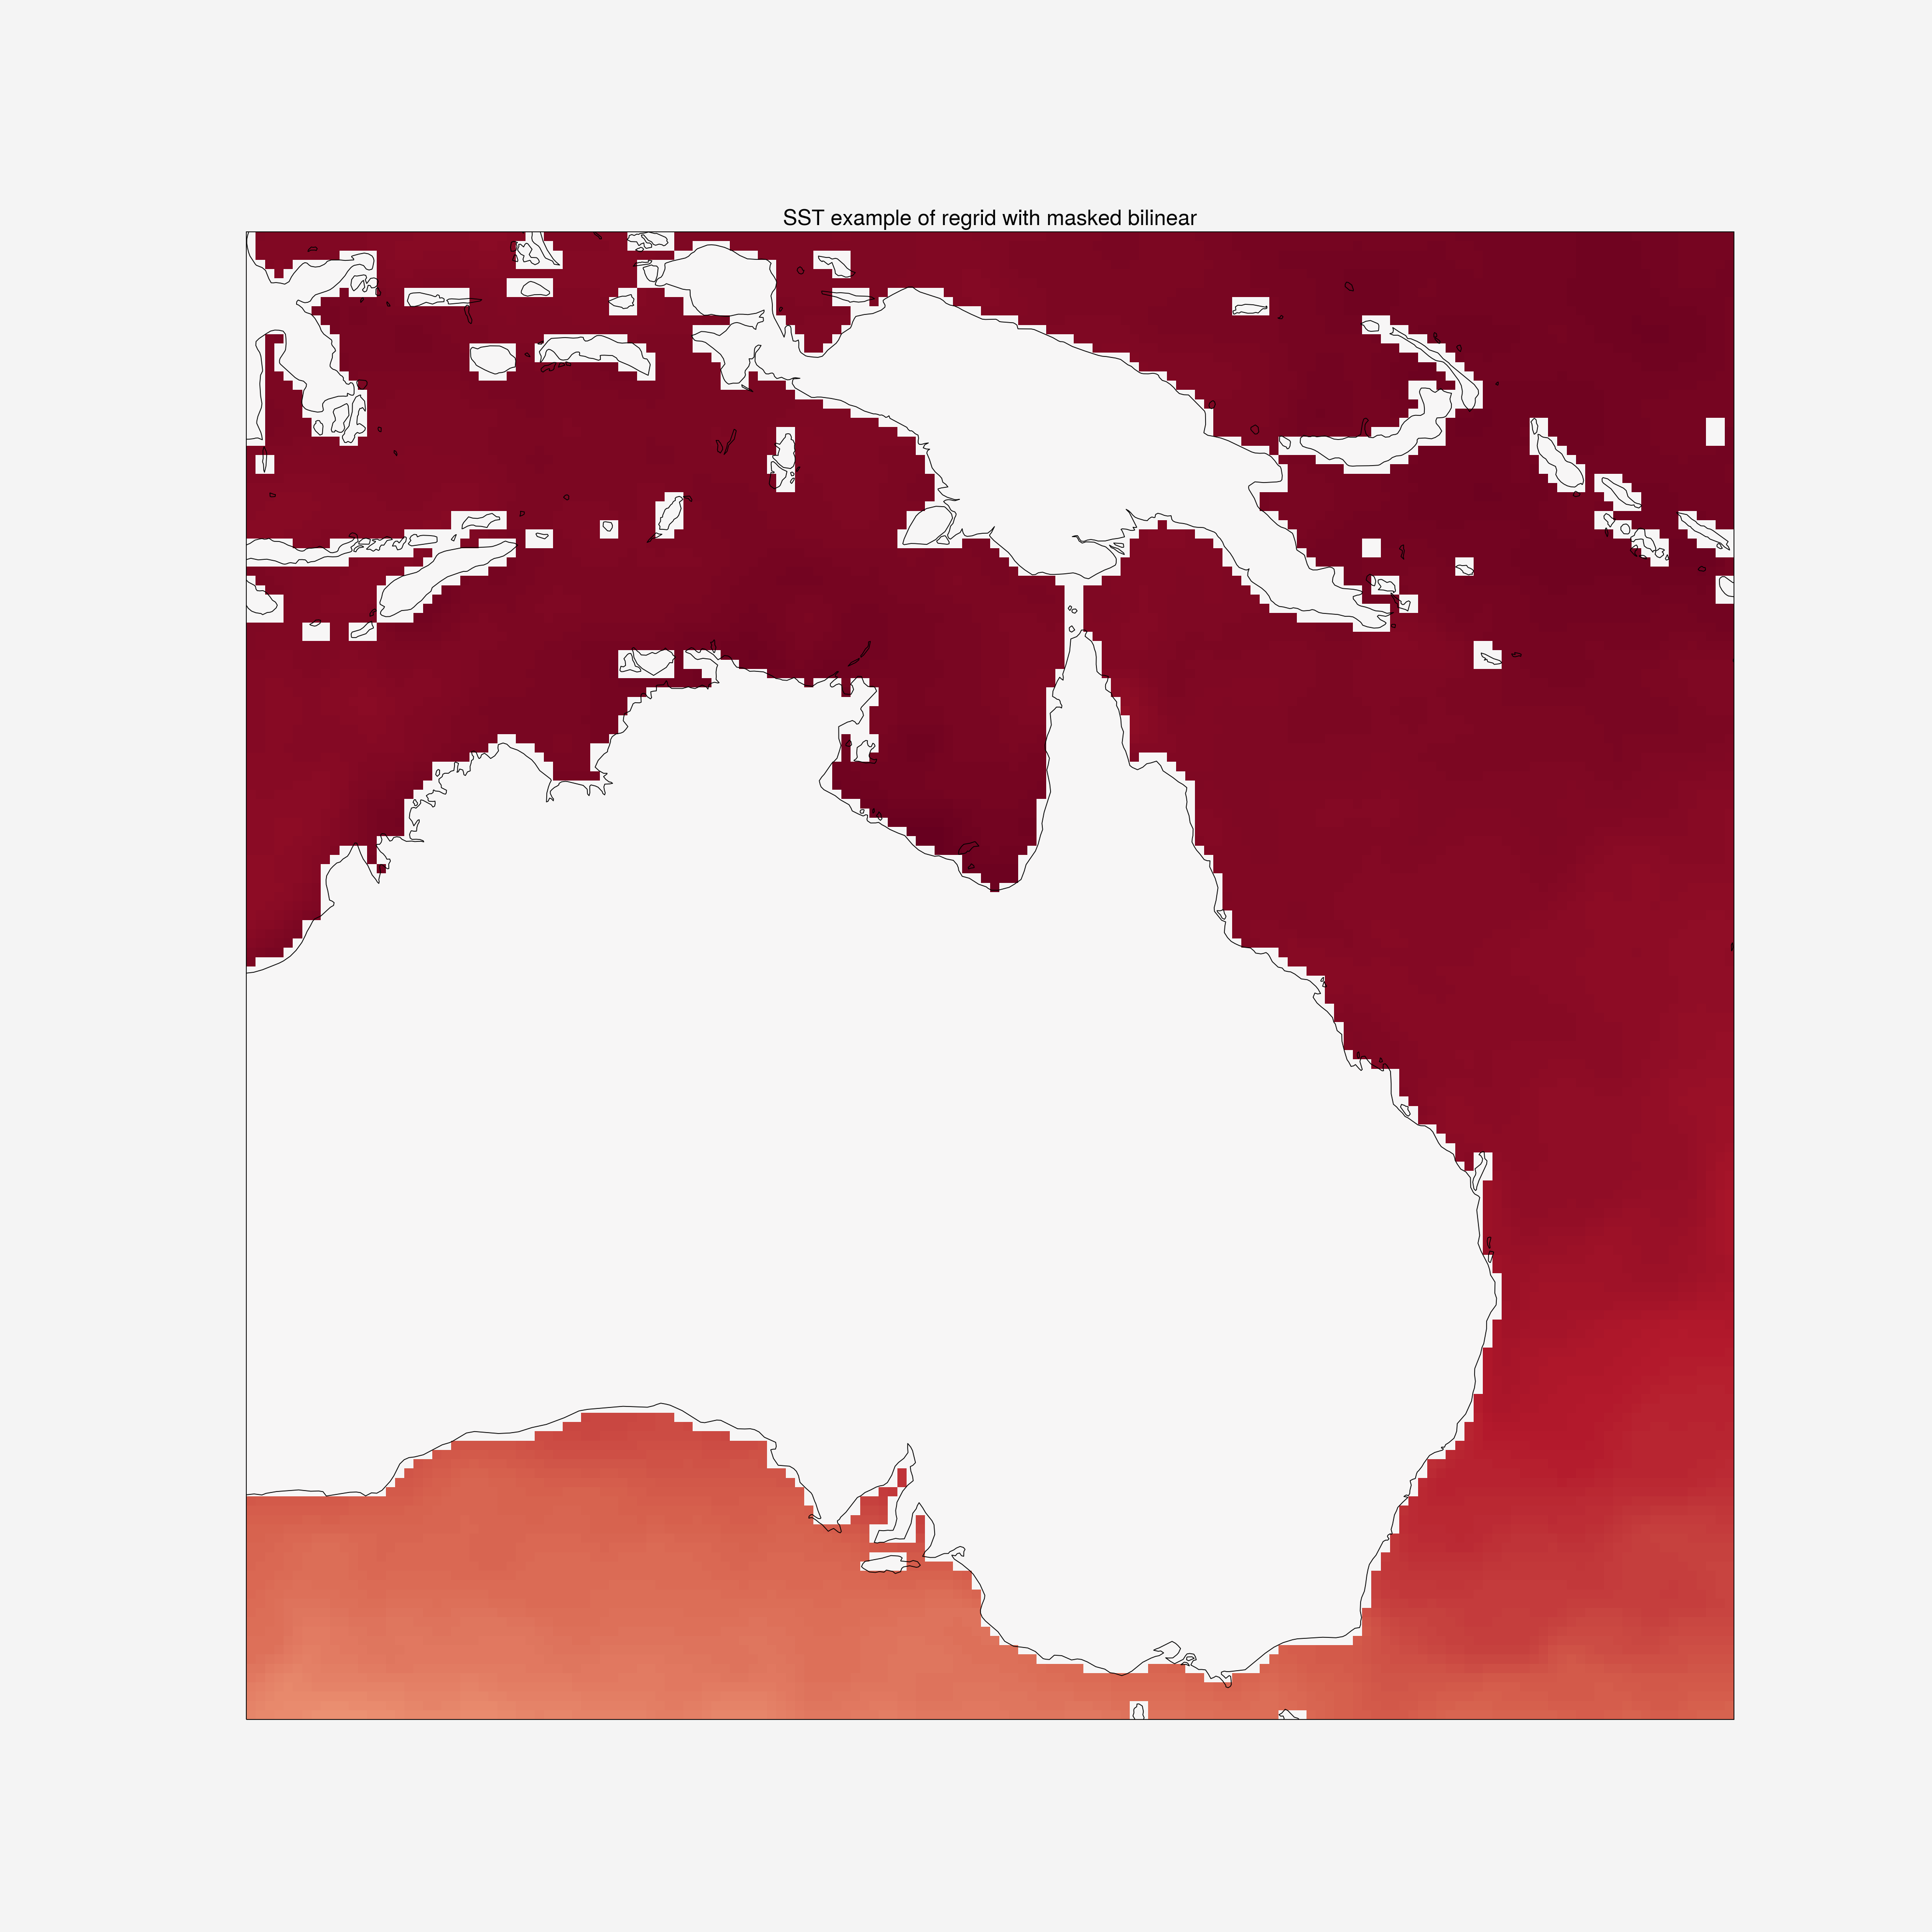

In [29]:
fig1 = plt.figure(figsize=(20,20),dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
SST_masked.plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), robust=False, add_colorbar=False
)
ax.set_title('SST example of regrid with masked bilinear', fontsize=16)
ax.coastlines()
ax.set_ylim([-40, 0])
ax.set_xlim([120, 160])

# TODO // commented out // Try conservative_normed?

# $ The\ End$

# Break glass in case of emergency
# $\Downarrow$

In [ ]:
client.restart()

tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7fcb04415430>>, <Task finished name='Task-304880' coro=<Scheduler.restart() done, defined at /g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/distributed/scheduler.py:5885> exception=CommClosedError("Exception while trying to call remote method 'restart' before comm was established.")>)
Traceback (most recent call last):
  File "/g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/distributed/comm/tcp.py", line 205, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/distributed/core.py", line 819, in send_recv_from_rpc
    result = awa

In [30]:
client.shutdown()

In [ ]:
client.restart()